# NARX and Recurrent Neural Networks
## Application to Ground Vibration Test of an F-16 aircraft. Description of the benchmark: https://www.nonlinearbenchmark.org/benchmarks/f-16-gvt

### EECI course on Deep Learning for System Identification
### Authors: Dario Piga, Marco Forgione
### Milano, July, 2025

## Goal: estimate mechanical vibrations on an F-16 aircraft in response to a shaker input

**- Inputs**: 
1. voltage measured at the output of the signal generator amplifier, acting as a reference input,
2. actual force provided by the shaker and measured by a impedance head at the excitation location.

**- Outputs:** acceleration signals measured:
1. at the excitation location ('Acceleration 1')
2. on the right wing next to the interface ('Acceleration 2')
3. on the payload next to the interface ('Acceleration 3')

# Exercise 1: NARX with Feedforward NNs:

- **Estimate a nonlinear model** describing the relation between the inputs and the three outputs.
- Since the two inputs are strongly correlated, you can use either both inputs in your model, or just one of them.
- Create three independent models, one for each output. Alternatively, create one single model with 3 outputs.
- Use a **Feed Forward Neural Network** taking in past measurements of the two inputs (up to time k) and  measurements of the output (up to time k-1), and returning an estimate of the output at time k. For a single output and two inputs, the structure is:
$$y(k) = \mathcal{F}(\overbrace{y(k-1), \dots, y(k-n_a), u_1(k), \dots, u_1(k - n_b + 1), u_2(k), \dots, u_2(k - n_b + 1)}^{=\phi(k)};\; W)$$
- **Test your results** on the dataset not used for training. Check the performance of your model both on 1-step ahead prediction and simulation. You can use the following metrics to assess the performance of your model:

\begin{align*}
\mathrm{RMSE} &= \sqrt{\frac{1}{T} \sum_{t=1}^T \big (y_t - \hat y_t \big)^2} \\
R^2 & = 1 - \frac{\sum_{t=1}^T \big (y_t - \hat y_t \big)^2}{\sum_{t=1}^T \big (y_t - \bar y_t \big)^2}
\end{align*}

## Step 0: Data ingestion and normalization (done)

Train and test datasets are saved in .csv  format.
- **Train dataset**: F16Data_SineSw_Level3
- **Test datasets**: F16Data_SineSw_Level4_Validation


In [55]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

# importing torch and other packages

import torch.nn.functional as F
from torchsummary import summary
from sklearn.metrics import r2_score

  
# Enable interactive figures for Jupyter Notebooks.
%matplotlib widget 

In [56]:
folder = os.path.join("..", "..", "data", "F16")
filename_train = os.path.join(folder, "F16Data_SineSw_Level3.csv")
filename_test = os.path.join(folder, "F16Data_SineSw_Level4_Validation.csv")

In [57]:
df_train = pd.read_csv(filename_train)
df_test = pd.read_csv(filename_test)

In [58]:
# data normalization
ds_mean = df_train.mean()
ds_std = df_train.std()
df_train = df_train - ds_mean / ds_std
df_test = df_test - ds_mean / ds_std

In [59]:
df_train.head()

,Force,Voltage,Acceleration1,Acceleration2,Acceleration3,Fs,Unnamed: 6
0,-0.018484,0.000011,0.000699,-0.002362,0.002817,NaN,NaN
1,-0.014168,0.000006,0.003286,0.000966,-0.004438,NaN,NaN
2,0.076786,0.000006,-0.006074,0.002666,0.001021,NaN,NaN
3,0.008705,0.000021,-0.004311,0.002797,0.002421,NaN,NaN
4,0.014639,0.000009,0.000723,0.000128,-0.001134,NaN,NaN


## Step 1: Data Exploration (TODO). 

Familiarize with the data. It is also a good practive to plot the input and output signals, see the length, mean and standard deviation, etc.

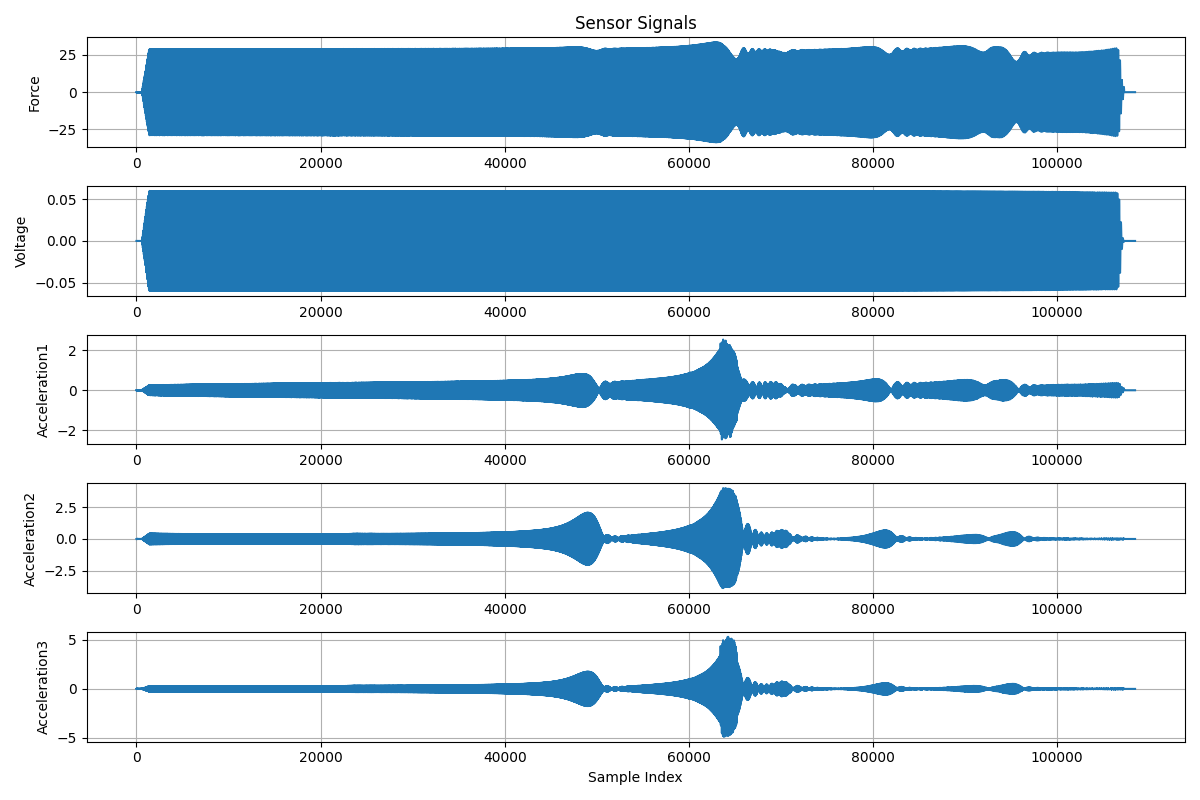

In [60]:
cols_to_plot = ['Force', 'Voltage', 'Acceleration1', 'Acceleration2', 'Acceleration3']

plt.figure(figsize=(12, 8))

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(df_train[col], label=col)
    plt.ylabel(col)
    plt.grid(True)
    if i == 1:
        plt.title('Sensor Signals')
    if i == len(cols_to_plot):
        plt.xlabel('Sample Index')

plt.tight_layout()

## Step 2: Lagged dataset preparation (sketched)

Create a dataset suitable for NARX training containing past measurements of inputs and output, with instances in the form:

$$\bigg ( \overbrace{y(k-1), \dots, y(k-n_a), u_1(k), \dots, u_1(k - n_b + 1), u_2(k), \dots, u_2(k - n_b + 1)}^{=\phi(k)}, \;\;y(k) \bigg)$$

In [61]:
output_vars = ["Acceleration1"]
input_vars = ["Force", "Voltage"]
na = 3
nb = 3

You may use/adapt the following ``lag_dataframe`` utility function, or follow a different approach

In [62]:
def lag_dataframe(ds, lag_min, lag_max, columns=None, fill_value=np.nan):
    """
    Create a dataframe containing lagged versions of variables in the input dataframe.
    lag_min: minimum lag
    lag_max: maximum lag
    columns: list of columns to lag, if None all columns are lagged
    fill_value: value to fill for missing data corresponding to negative time stamps
    """
    lagged_dict = {}
    lagged_vars = []
    columns = columns if columns is not None else ds.columns
    for var in columns:
        for lag in range(lag_min, lag_max+1):
            lagged_var = f"{var}(k-{lag})" if lag > 0 else f"{var}(k)"  # 'var(k-i)
            lagged_dict[lagged_var] = ds[var].shift(lag, fill_value=fill_value).copy()
            lagged_vars.append(lagged_var)
    ds_lag = pd.DataFrame(lagged_dict)
    return ds_lag,lagged_vars

# Create lag data for train and test (phi vect)



In [63]:
# usage of the lag_dataframe utility function
ds_lag_train, lagged_vars_train = lag_dataframe(df_train[input_vars], lag_min=0, lag_max=nb)
ds_lag_y_train, lagged_vars_y_train = lag_dataframe(df_train[output_vars], lag_min=0, lag_max=na)
ds_lag_train.head()
# ds_lag_y.head()

,Force(k),Force(k-1),Force(k-2),Force(k-3),Voltage(k),Voltage(k-1),Voltage(k-2),Voltage(k-3)
0,-0.018484,NaN,NaN,NaN,0.000011,NaN,NaN,NaN
1,-0.014168,-0.018484,NaN,NaN,0.000006,0.000011,NaN,NaN
2,0.076786,-0.014168,-0.018484,NaN,0.000006,0.000006,0.000011,NaN
3,0.008705,0.076786,-0.014168,-0.018484,0.000021,0.000006,0.000006,0.000011
4,0.014639,0.008705,0.076786,-0.014168,0.000009,0.000021,0.000006,0.000006


In [64]:

ds_lag_test, lagged_vars_test = lag_dataframe(df_test[input_vars], lag_min=0, lag_max=nb)
ds_lag_y_test, lagged_vars_y_test = lag_dataframe(df_test[output_vars], lag_min=0, lag_max=na)
ds_lag_test.head()
# ds_lag_y.head()

,Force(k),Force(k-1),Force(k-2),Force(k-3),Voltage(k),Voltage(k-1),Voltage(k-2),Voltage(k-3)
0,-0.010500,NaN,NaN,NaN,-0.000006,NaN,NaN,NaN
1,0.055477,-0.010500,NaN,NaN,-0.000003,-0.000006,NaN,NaN
2,0.093347,0.055477,-0.010500,NaN,0.000004,-0.000003,-0.000006,NaN
3,0.007626,0.093347,0.055477,-0.010500,0.000002,0.000004,-0.000003,-0.000006
4,0.030500,0.007626,0.093347,0.055477,0.000006,0.000002,0.000004,-0.000003


In [65]:
data_lag_train = pd.concat([ds_lag_y_train,ds_lag_train], axis=1)
data_lag_train = data_lag_train.dropna().reset_index(drop=True)
# data_lag_train = data_lag_train.shift(1)
data_lag_train.head()

,Acceleration1(k),Acceleration1(k-1),Acceleration1(k-2),Acceleration1(k-3),Force(k),Force(k-1),Force(k-2),Force(k-3),Voltage(k),Voltage(k-1),Voltage(k-2),Voltage(k-3)
0,-0.004311,-0.006074,0.003286,0.000699,0.008705,0.076786,-0.014168,-0.018484,0.000021,0.000006,0.000006,0.000011
1,0.000723,-0.004311,-0.006074,0.003286,0.014639,0.008705,0.076786,-0.014168,0.000009,0.000021,0.000006,0.000006
2,-0.002476,0.000723,-0.004311,-0.006074,-0.004026,0.014639,0.008705,0.076786,0.000021,0.000009,0.000021,0.000006
3,0.001828,-0.002476,0.000723,-0.004311,-0.088830,-0.004026,0.014639,0.008705,0.000017,0.000021,0.000009,0.000021
4,-0.000124,0.001828,-0.002476,0.000723,-0.019778,-0.088830,-0.004026,0.014639,0.000019,0.000017,0.000021,0.000009


In [66]:
data_lag_test = pd.concat([ds_lag_y_test,ds_lag_test], axis=1)
data_lag_test = data_lag_test.dropna().reset_index(drop=True)
# data_lag_test = data_lag_test.shift(1)
data_lag_test.head()

,Acceleration1(k),Acceleration1(k-1),Acceleration1(k-2),Acceleration1(k-3),Force(k),Force(k-1),Force(k-2),Force(k-3),Voltage(k),Voltage(k-1),Voltage(k-2),Voltage(k-3)
0,0.000182,-0.004040,0.000981,-0.000877,0.007626,0.093347,0.055477,-0.010500,0.000002,0.000004,-0.000003,-0.000006
1,0.001311,0.000182,-0.004040,0.000981,0.030500,0.007626,0.093347,0.055477,0.000006,0.000002,0.000004,-0.000003
2,-0.004216,0.001311,0.000182,-0.004040,-0.040494,0.030500,0.007626,0.093347,0.000004,0.000006,0.000002,0.000004
3,0.005050,-0.004216,0.001311,0.000182,-0.086025,-0.040494,0.030500,0.007626,-0.000011,0.000004,0.000006,0.000002
4,0.000017,0.005050,-0.004216,0.001311,0.008975,-0.086025,-0.040494,0.030500,-0.000011,-0.000011,0.000004,0.000006


Define PyTorch's Dataset and DataLoader

In [67]:
epochs = 500
lr = 1e-3
batch_size = 256

y_train = data_lag_train[['Acceleration1(k)']]  # keep as DataFrame (shape [n, 1])
phi_train = data_lag_train.drop(columns=['Acceleration1(k)'])  # drop the target column

phi_train_torch = torch.tensor(phi_train.values, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32)

y_test = data_lag_test[['Acceleration1(k)']]  # keep as DataFrame (shape [n, 1])
phi_test = data_lag_test.drop(columns=['Acceleration1(k)'])  # drop the target column

phi_test_torch = torch.tensor(phi_test.values, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32)

input_size = phi_train_torch.shape[1] 
output_size = y_train_torch.shape[1]
hidden_sizes = [32, 64]

print(f"In: {input_size}")
print(f"Out: {output_size}")
print(f"Hidd: {hidden_sizes}")


In: 11
Out: 1
Hidd: [32, 64]


In [68]:
train_ds = TensorDataset(phi_train_torch, y_train_torch)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
print(phi_train_torch)
print(y_train_torch)



tensor([[-6.0745e-03,  3.2863e-03,  6.9916e-04,  ...,  6.4311e-06,
          6.4311e-06,  1.1314e-05],
        [-4.3106e-03, -6.0745e-03,  3.2863e-03,  ...,  2.1079e-05,
          6.4311e-06,  6.4311e-06],
        [ 7.2268e-04, -4.3106e-03, -6.0745e-03,  ...,  8.8725e-06,
          2.1079e-05,  6.4311e-06],
        ...,
        [-5.3467e-05, -5.3467e-05, -5.3467e-05,  ...,  1.5483e-06,
          1.5483e-06,  1.5483e-06],
        [-5.3467e-05, -5.3467e-05, -5.3467e-05,  ...,  1.5483e-06,
          1.5483e-06,  1.5483e-06],
        [-5.3467e-05, -5.3467e-05, -5.3467e-05,  ...,  1.5483e-06,
          1.5483e-06,  1.5483e-06]])
tensor([[-4.3106e-03],
        [ 7.2268e-04],
        [-2.4760e-03],
        ...,
        [-5.3467e-05],
        [-5.3467e-05],
        [-5.3467e-05]])


## Step 3: Network Definition (sketched). 

Define a class for your network (see template below)

In [77]:
class FeedforwardNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        
        layers = []

        # Input layer to first hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.Tanh())  # or another activation

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.Tanh())

        # Last hidden to output
        layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Combine into Sequential model
        self.narx_nn = nn.Sequential(*layers)

    def forward(self, x):
        x = self.narx_nn(x)

        return x
    
model = FeedforwardNeuralNetwork(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size)


In [78]:
params_nn = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable model parameters: {params_nn}")

summary(model, input_size=(batch_size, input_size), device="cpu")

for name, param in model.named_parameters():
    print(name, param.requires_grad)

Total number of trainable model parameters: 2561
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 256, 32]             384
              Tanh-2              [-1, 256, 32]               0
            Linear-3              [-1, 256, 64]           2,112
              Tanh-4              [-1, 256, 64]               0
            Linear-5               [-1, 256, 1]              65
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.38
Params size (MB): 0.01
Estimated Total Size (MB): 0.40
----------------------------------------------------------------
narx_nn.0.weight True
narx_nn.0.bias True
narx_nn.2.weight True
narx_nn.2.bias True
narx_nn.4.weight True
narx_nn.4.bias True


## Step 4: Training (TODO).
Train your network (see template below, complete it and/or modify it as you like)

In [80]:

# Dataset, DataLoader Loss, and Optimizer
criterion = nn.MSELoss() # we may also define the loss manually in the training loop
optimizer = optim.Adam(model.parameters(), lr=lr)

LOSS = []

# Optimization loop
for epoch in range(epochs):
    loss_epoch = 0.0 # just for diagnostic, we track the average loss in the training epoch

    for batch_x, batch_y in train_dl:
        optimizer.zero_grad()
        batch_y_pred = model(batch_x)
        loss = criterion(batch_y_pred, batch_y)
        # loss = torch.mean((batch_y_pred - batch_y)**2) 
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        
    loss_epoch /= len(train_dl) # divide by number of batches per epoch to get an average
    LOSS.append(loss_epoch)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_epoch:.4f}", end="\r") # diagnostic output (once per epoch here)

## Step 5: Performance assessment (TODO) 

Assess performance on test dataset (it is also a good practice to first assess performance in the training dataset) 

Performance should be assessed in terms of one-step ahead prediction and simulation.

To quantify the performance, compute the RMSE, the $R^2$ coefficient, plot true output and estimate output.

# Exercise 2: Recurrent Neural Networks:

Repeat the same exercise, but **use an RNN network** (either Vanilla RNN or LSTM) instead of a feedforward network. This allows you to look multi-step ahead in your training, rather than than simple 1-step.

Hyper-parameter to select:
* structure of the network (namely, size of hidden state, number of layers)
* sub-sequence length for training
* optimization hyper-parameters (learning rate, maximum number of epochs)


## Data ingestion and normalization (done)

In [ ]:
folder = os.path.join("..", "..", "data", "F16")
filename_train = os.path.join(folder, "F16Data_SineSw_Level3.csv")
filename_test = os.path.join(folder, "F16Data_SineSw_Level4_Validation.csv")

In [ ]:
df_train = pd.read_csv(filename_train)
df_test = pd.read_csv(filename_test)

In [ ]:
# data normalization
ds_mean = df_train.mean()
ds_std = df_train.std()
df_train = df_train - ds_mean / ds_std
df_test = df_test - ds_mean / ds_std

In [ ]:
output_vars = ["Acceleration1"]
input_vars = ["Force", "Voltage"]
seq_len = 2000

In [ ]:
df_train[input_vars]

,Force,Voltage
0,-0.018484,0.000011
1,-0.014168,0.000006
2,0.076786,0.000006
3,0.008705,0.000021
4,0.014639,0.000009
...,...,...
108472,-0.000034,0.000002
108473,-0.000034,0.000002
108474,-0.000034,0.000002
108475,-0.000034,0.000002


## Sequence DataSet preparation (sketched)

You may exploit the custom PyTorch Dataset defined in the pytorch_sysid.ipynb notebook

In [ ]:
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    r"""A dataset returning sub-sequences extracted from longer sequences.
        For simplicity, this version does not support overlapping subsequences.
    Args:
        *tensors (Tensor): tensors that have the same size on the first dimension.
    Examples:
        >>> u = torch.randn(1000, 2) # 2 inputs
        >>> y = torch.randn(1000, 3) # 3 outputs
        >>> train_dataset = SequenceDataset(u, y, seq_len=100)
    """

    def __init__(self, *tensors, seq_len):
        self.tensors = tensors

        self.seq_len = seq_len
        assert all(tensor.shape[0] == self.tensors[0].shape[0] for tensor in self.tensors), "All tensors must have the same length"
        self.total_len = self.tensors[0].shape[0]

    def __len__(self):
        return int(self.total_len // self.seq_len)

    def __getitem__(self, idx):
        start = idx * self.seq_len
        stop = start + self.seq_len
        return [tensor[start:stop] for tensor in self.tensors]

In [ ]:
# Datasets
train_ds = SequenceDataset(
    torch.Tensor(df_train[input_vars].values).type(torch.Tensor),
    torch.Tensor(df_train[output_vars].values).type(torch.Tensor),
    seq_len=seq_len
)

... # continue with the test dataset

Ellipsis